`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   

# Лабораторная работа №3,4: Парсинг сайтов и анализ текстовой информации

*Данные*: раздел "авто" на сайте [irecommend.ru/catalog/list/2](https://irecommend.ru/catalog/list/2)

### Загрузка пакетов

In [2]:
import re
import nltk
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
from random import randint
from pymystem3 import Mystem
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.probability import FreqDist
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MKN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Загрузка и проверка данных

In [11]:
# Список для хранения информации о товарах 
products_info = []

# Проходим по каждой странице 
for page_num in range(0, 30):
    url = f'https://irecommend.ru/catalog/list/2?page={page_num}'
    r = requests.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    
    products = soup.find_all('div', class_='ProductTizer plate teaser-item')
    
    for product in products:
        title = product.find('div', class_='title').text
        mean_rating = product.find('span', class_='average-rating').find('span').text
        products_info.append((title, mean_rating))
        
    print(f'{page_num+1}', end=' ')
    sleep(randint(8, 11))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 

In [12]:
if len(products_info) == 600:
    print('All elements are parsed')
    df = pd.DataFrame(products_info, columns=['title', 'mean_rating'])
else:
    print('Something went wrong, count of products_info less or more than expected')

All elements are parsed


In [13]:
df.head()

,title,mean_rating
0,ВАЗ 2107 - 2003,3.9
1,Chevrolet Lanos - 2006,4.2
2,Фильтр салона TopCover T1238-3004,5
3,Чехлы для колес New Galaxy R13-17,5
4,Автомасла SINTEC Super 10W-40,4.7


### Первичный анализ данных

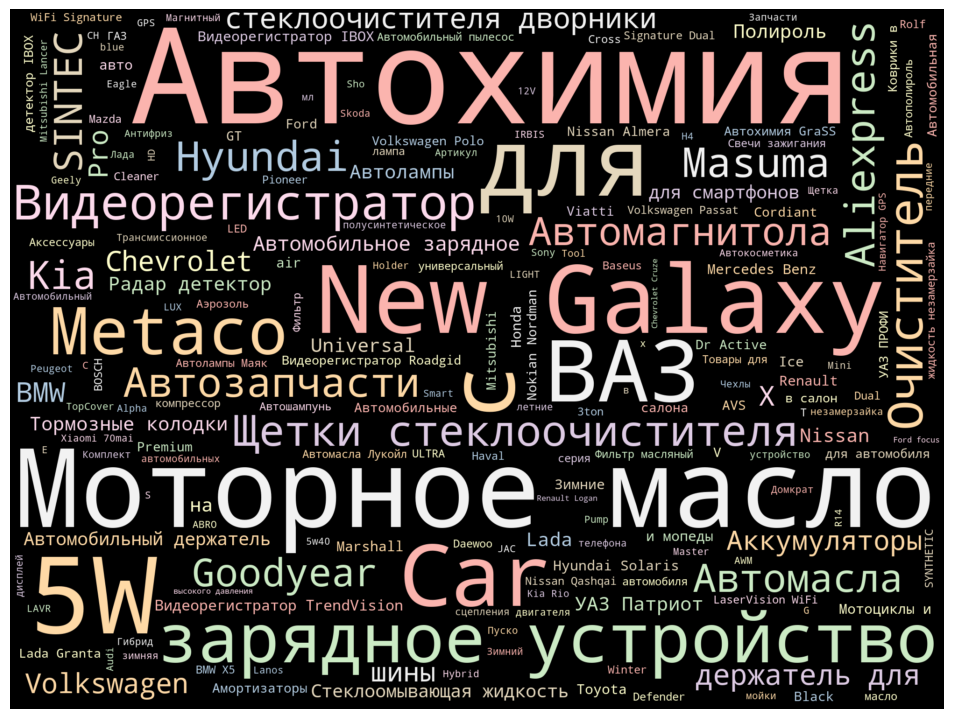

In [14]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Можно заметить насколько часто используется слово "Автохимия" или чуть поменьше "5W" в названиях товаров. Необходимо привести данные к нижнему регистру, почистить от стоп-слов, знаков препинания, одиночных чисел и символов, а также привести к нормальной форме.

### Обработка данных

In [15]:
stop_words = stopwords.words("russian")
m = Mystem()

def clean_title_lemmatize(title):
    title = title.lower()
    title = re.sub(r'[^\w\s]', '', title)
    title = re.sub(r'\b\d+\b', '', title)
    title = re.sub(r'\b\w{1,2}\b', '', title)
    words = word_tokenize(title)
    words = [word for word in words if word not in stop_words]
    title = ' '.join(words)
    lemmas = m.lemmatize(title)
    return ''.join(lemmas).replace('\n', '')

In [16]:
df['title'] = df['title'].apply(clean_title_lemmatize)

In [17]:
df.head()

,title,mean_rating
0,ваз,3.9
1,chevrolet lanos,4.2
2,фильтр салон topcover t12383004,5
3,чехол колесо new galaxy r1317,5
4,автомасло sintec super 10w40,4.7


### Анализ после обработки

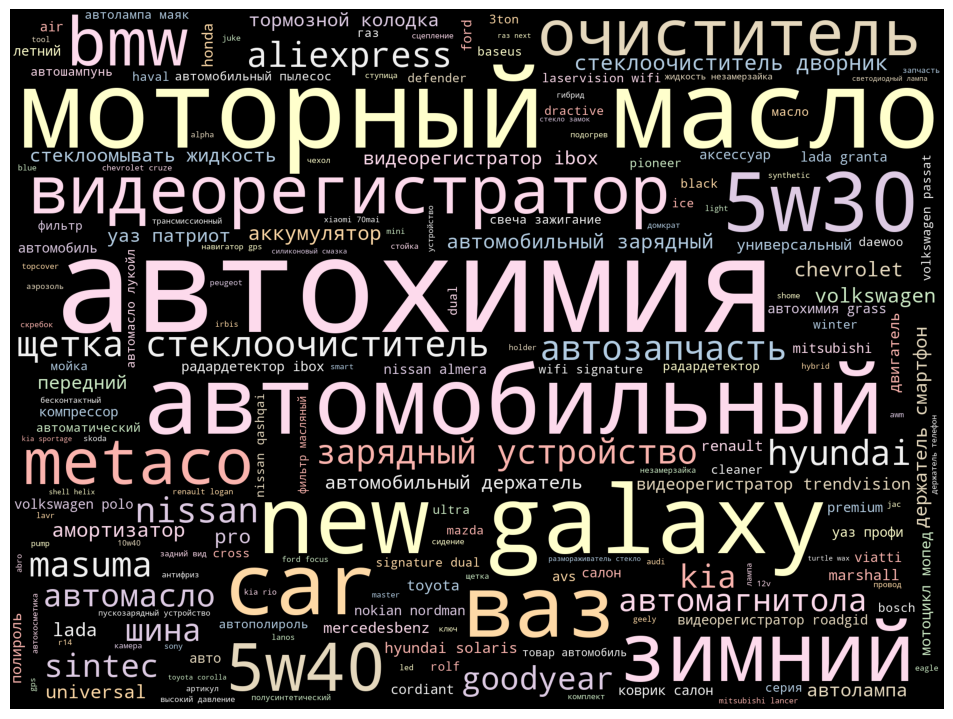

In [18]:
wordcloud = WordCloud(width=2000, height=1500, background_color='black',
                      colormap='Pastel1', min_font_size=15, margin=15).generate(' '.join(df['title']))

plt.figure(figsize=(15, 7), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Нам удалось обработать текст и выделить наиболее часто встречающиеся темы, которые относятся к разделу "авто".

### Частотный анализ слов

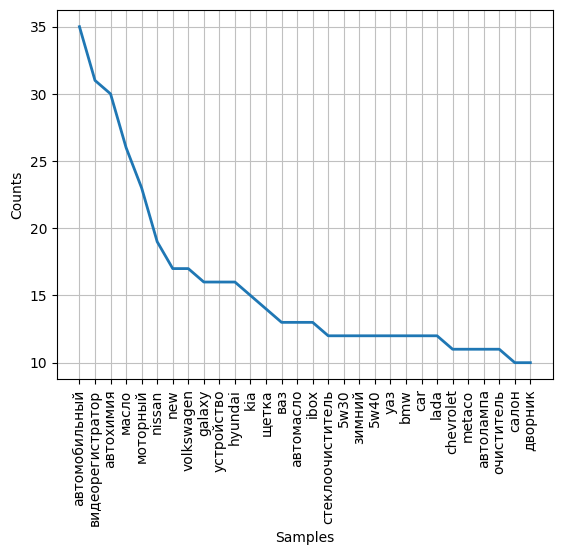

In [19]:
fdist = FreqDist()

for title in df['title']:
    for word in title.split():
        fdist[word] += 1

fdist.plot(30)
plt.show()

Скорее всего, разделение может быть произведено по:

* Автомобили
* Видеорегистраторы
* Запчасти
* Резина
* Автохимия
* Бренды автомобилей

### Разделение с помощью TfidVectorizer и CountVectorizer

In [20]:
titles = df['title']

tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['title'])

n_clusters = 10
tfidf_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
tfidf_clusters = tfidf_kmeans.fit_predict(tfidf_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[tfidf_clusters == i])
    print()

Cluster 1:
582    lexus rx300
Name: title, dtype: object

Cluster 2:
8                              моторный масло mirax 5w30
9                  трансмиссионный масло lifeguard fluid
42                          моторный масло ngn gold 5w40
45               моторный масло sintec platinum sae 5w30
48                            моторный масло toyota 5w30
83     автомасло лукойл моторный полусинтетический ав...
90                        автомасло rolf 3synthetic 5w40
116                   моторный масло sintec premium 5w30
124                    моторный масло tcl 5w30 синтетика
148                        автомасло sintec premium 5w30
161                               моторный масло genergy
199                      автомасло лукойл люкс 5w30 slcf
213         моторный масло wolf official tech 5w30 extra
263                     моторный масло газпромнефть 5w40
269         моторный масло shell helix high mileage 5w40
276         моторный масло idemitsu zepro euro spec 5w40
277                

In [21]:
count_vectorizer = CountVectorizer()
count_vectors = count_vectorizer.fit_transform(titles)

count_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
count_clusters = count_kmeans.fit_predict(count_vectors)

for i in range(n_clusters):
    print(f"Cluster {i+1}:")
    print(titles[count_clusters == i])
    print()

Cluster 1:
435    предпусковой подогреватель bros помпа квт litt...
Name: title, dtype: object

Cluster 2:
37                         видеорегистратор xiaomi 70mai
46            видеорегистратор roadgid blick wifi камера
49     радардетектор ibox nova laservision wifi signa...
50                    радардетектор ibox smart signature
59     гибрид радардетектор видеорегистратор ibox evo...
65                              видеорегистратор roadgid
106                          видеорегистратор new galaxy
177                 видеорегистратор roadgid citygo wifi
190    видеорегистратор shome sfhd 3в1 зеркало камера...
192             видеорегистратор new galaxy full дисплей
197         видеорегистратор ibox roadscan wifi gps dual
206       видеорегистратор new galaxy зеркало задний вид
223    видеорегистратор xiaomi 70mai smart dash cam p...
296    радардетектор ibox icon laservision wifi signa...
304                     видеорегистратор daocam uno wifi
307                 видеорегистратор r

TfidfVectorizer в большинстве случаях всегда будет давать более хорошие результаты, так как он учитывает не только частоту слов, но и их важность в тексте.
Примерные его группы разбиения:
1) Lexus rx300

2) Автомобильное масло

3) УАЗ


4) ВАЗ

5) Видеоргистраторы и автомобильная электрика

6) Автохимия и шины

7) Автомобильные аксессуары и устройства

8) Hyundai

9) Kia

10) Автомобильная продукция и запчасти

### Визуализация разбиения

In [22]:
def make_cooccurrence_matrix(texts):
  # Зададим словарь и попарную частоту совместной встречаемости слов
  vocabulary = set(texts[0].split())
  for t in texts[1:]:
    vocabulary = vocabulary.union(set(t.split()))
  vocabulary=list(vocabulary)

  N = len(vocabulary)
  
  # Задаём cooccurrence matrix
  cooccurrence = np.zeros((N,N))
  for i in range(N):
    for j in range(i, N):
      if i == j:
        continue
      for t in texts:
        if vocabulary[i] in t.split() and vocabulary[j] in t.split():
          cooccurrence[i][j]+=1
          cooccurrence[j][i]+=1
  return cooccurrence, vocabulary

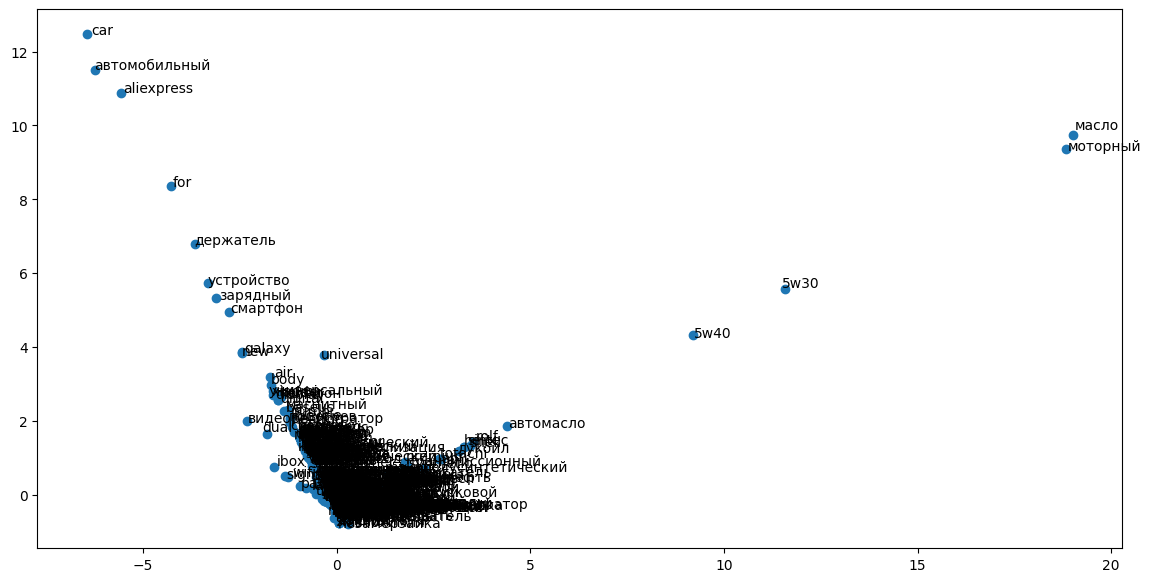

In [23]:
text_list = df['title'].tolist()

c, v = make_cooccurrence_matrix(text_list)

p = PCA(n_components=2)
pca = p.fit_transform(c)

plt.figure(figsize=(14,7))
ax = plt.gca()
for i, c in enumerate(pca):
    ax.annotate(text = v[i], xy = (c[0] + np.random.randn()/15, c[1]+ np.random.randn()/15))
plt.scatter(pca[:,0], pca[:,1])
plt.show()

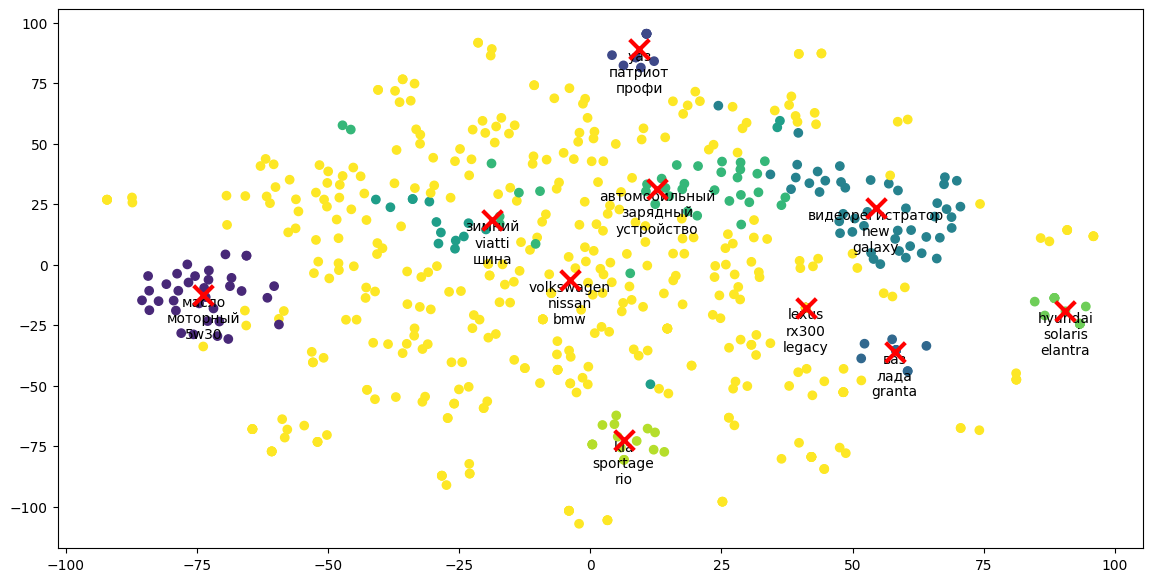

In [24]:
tsne = TSNE(n_components=2)
reduced_vectors = tsne.fit_transform(tfidf_vectors.toarray())

centroids = np.zeros((n_clusters, 2))
for i in range(n_clusters):
    centroids[i] = np.mean(reduced_vectors[tfidf_clusters == i], axis=0)

plt.figure(figsize=(14, 7))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=tfidf_clusters)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, linewidths=3, color='r', zorder=10)

for i in range(n_clusters):
    cluster_words = tfidf_vectors[tfidf_clusters == i].toarray().sum(axis=0)
    top_words_indices = cluster_words.argsort()[-3:][::-1]
    top_words = [tfidf_vectorizer.get_feature_names_out()[index] for index in top_words_indices]
    plt.annotate('\n'.join(top_words), (centroids[i, 0], centroids[i, 1]), ha='center', va='top')

plt.show()

### Подсчёт характеристик

In [25]:
df['mean_rating'] = df['mean_rating'].astype(float)
df['cluster'] = tfidf_clusters

In [26]:
title_count = df.groupby('cluster')['title'].count()
sum_mean_rating = df.groupby('cluster')['mean_rating'].sum()
mean_rating = df.groupby('cluster')['mean_rating'].mean()

stats_df = pd.concat([title_count, sum_mean_rating, mean_rating], axis=1)
stats_df.columns = ['title_count', 'sum_mean_rating', 'mean_rating']

stats_df

,title_count,sum_mean_rating,mean_rating
cluster,,,
0,1,5.0,5.000000
1,34,164.4,4.835294
2,12,50.6,4.216667
3,13,54.1,4.161538
4,46,202.9,4.410870
5,16,67.4,4.212500
6,36,159.3,4.425000
7,15,71.9,4.793333
8,15,70.6,4.706667


Анализируя данную таблицу, можно сделать следующие выводы:

Товары из 0-го кластера (Lexus rx300) (всего один товар) имеют идеальный средний рейтинг 5.0, что говорит о высоком качестве товара, но сложно делать выводы из-за отсутствия других товаров в этом кластере.

Товары из 1-го кластера (автомобильное масло), состоящего из 34 товаров, имеют второй по величине средний рейтинг (4.835294) и являются популярными среди пользователей. Это может говорить о высоком качестве товаров в данном кластере.

Товары из 7-го (Hyundai) и 8-го (Kia) кластеров, состоящие каждый из 15 товаров, имеют третий и четвёртый по величине средний рейтинг (4.793333) и (4.706667), что говорит о хорошем качестве товаров в данных кластерах.

Товары из 9-го кластера (автомобильная продукция и запчасти) являются наиболее многочисленными (412 товаров) и имеют средний рейтинг 4.565534, что также указывает на их популярность среди пользователей и хорошее качество.

Товары из кластеров 4 (4.410870) (видеоргистраторы и автомобильная электрика) и 6 (4.425000) (автомобильные аксессуары и устройства) также имеют высокие средние рейтинги, что указывает на хорошее качество товаров в этих кластерах.

Кластеры 2 (4.216667) (УАЗ), 3 (4.161538) (ВАЗ) и 5 (4.212500) (автохимия и шины) имеют относительно низкие средние рейтинги по сравнению с другими кластерами, что может говорить о более низком качестве товаров или более узкой целевой аудитории. Однако стоит отметить, что все средние рейтинги выше 4, что указывает на то, что товары во всех кластерах в целом имеют положительные отзывы.